In [20]:
import matplotlib.pyplot as plt
%matplotlib inline    
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys, copy
from pathlib import Path
lib_dir = (Path("__file__").parent).resolve()
if str(lib_dir) not in sys.path: sys.path.insert(0, str(lib_dir))
from FastAutoAugment.networks import WideResNet
from FastAutoAugment.data import get_dataloaders, get_gr_dist
from theconf import Config as C, ConfigArgumentParser
from PIL import Image
from sklearn.manifold import TSNE
from matplotlib.pyplot import cm
from FastAutoAugment.networks import get_model, num_class
from FastAutoAugment.metrics import accuracy
import numpy as np
from collections import Counter
import pandas as pd

In [21]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [22]:
C.get()["aug"] = "default"
C.get()["cutout"] = 16
C.get()["cv_num"] = 5

In [26]:
exp_name = "log_test"
# result = torch.load(f"/home/server08/yongsu/fast-autoaugment/FastAutoAugment/models/{exp_name}/summary.pt")
search_result = torch.load(f"/home/server08/yongsu/fast-autoaugment/FastAutoAugment/models/{exp_name}/search_summary.pt")
repeat = 2
cv_num = 5
gr_num = 2
num_classes = 10
print(search_result.keys())
# print(result.keys())

RuntimeError: /home/server08/yongsu/fast-autoaugment/FastAutoAugment/models/log_test/search_summary.pt is a zip archive (did you mean to use torch.jit.load()?)

10


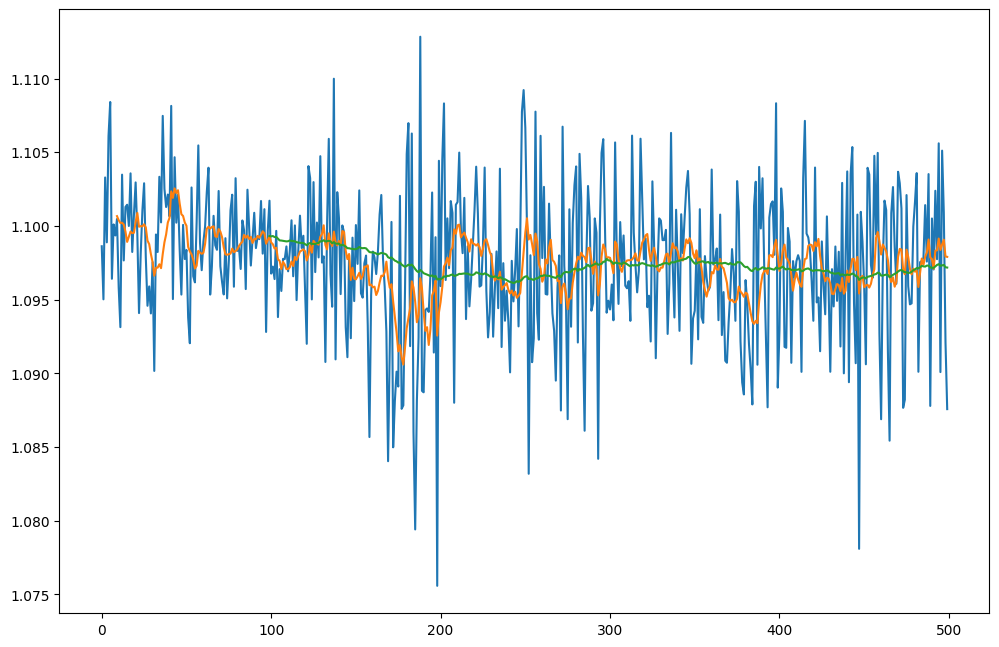

In [5]:
reports = search_result['gr_results']
print(len(reports))
df = pd.DataFrame([x for pol in reports for x in pol])
plt.plot(df[0])
plt.plot(df[0].rolling(window=10).mean())
plt.plot(df[0].rolling(window=100).mean())
# plt.axhline(y=0,c='red')
plt.show()

10


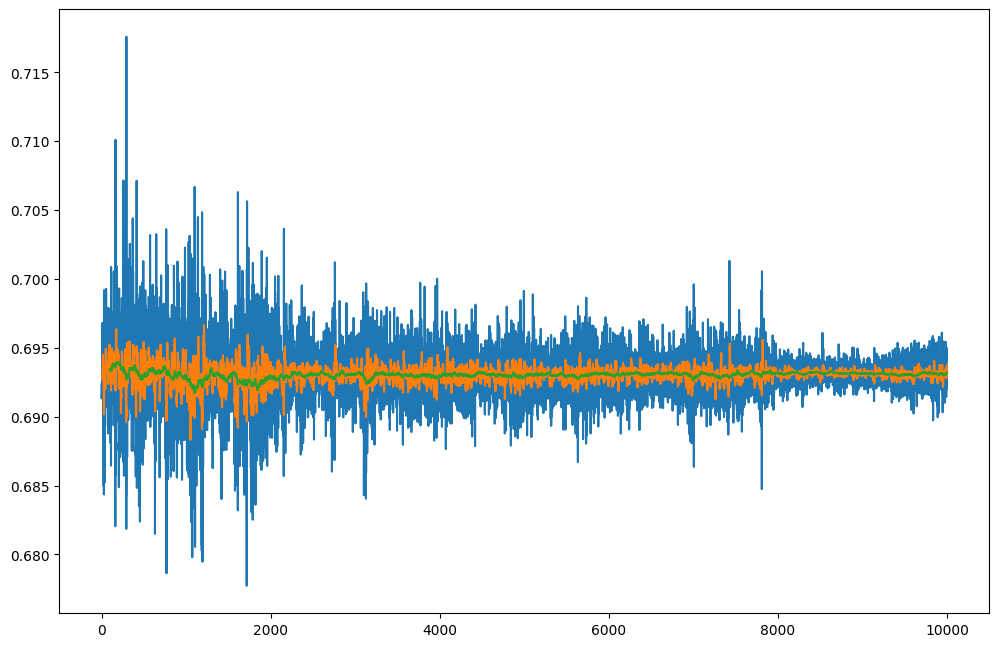

In [25]:
# supervised result
reports = search_result['gr_results']
print(len(reports))
df = pd.DataFrame([x for pol in reports for x in pol])
plt.plot(df[0])
plt.plot(df[0].rolling(window=10).mean())
plt.plot(df[0].rolling(window=100).mean())
plt.show()

10


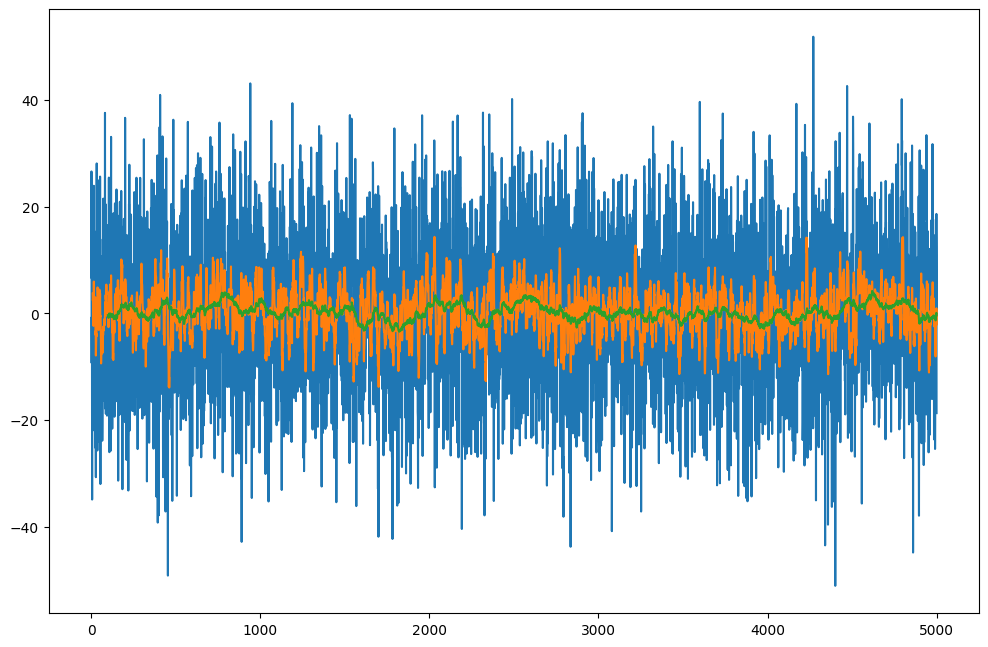

In [29]:
# reinforce result
reports = search_result['gr_results']
print(len(reports))
df = pd.DataFrame([x for pol in reports for x in pol])
plt.plot(df[0])
plt.plot(df[0].rolling(window=10).mean())
plt.plot(df[0].rolling(window=100).mean())
plt.show()

In [8]:
gr_dist_move = search_result['gr_dist_collector']
print(len(gr_dist_move))
print(len(gr_dist_move[0]))
print(len(gr_dist_move[0][0]))

6
2
50000


In [7]:
dataset = "reduced_cifar10"
batch = 128
dataroot = "/home/server08/data"
split = 0.0
C.get()['aug'] = 'clean'
total_trainset, test = get_gr_dist(dataset, batch, dataroot, split_idx=0, get_dataset=True)

In [9]:
childnet = WideResNet(28, 10, dropout_rate=0.0, num_classes=num_classes).cuda()
path = "/home/server08/yongsu/fast-autoaugment/FastAutoAugment/models/reduced_cifar10_wresnet28_10_default_ratio0.4_fold0.model"
ckpt = torch.load(path)
if 'model' in ckpt:
    childnet.load_state_dict(ckpt['model'])
else:
    childnet.load_state_dict(ckpt)
childnet.feature_out = True
loader = torch.utils.data.DataLoader(
                    total_trainset, batch_size=128, shuffle=False, num_workers=4,
                    drop_last=False)

In [10]:
features = []
for data, label in loader:
    data = data.cuda()
    feature = childnet(data)
    features.append(feature.cpu().detach().numpy())
    del data, label
del childnet
fts = np.concatenate(features)
print(fts.shape)

(50000, 640)


In [11]:
model = TSNE(learning_rate=200, n_iter=1000, perplexity=50, verbose=1, n_jobs=-1)
transformed = model.fit_transform(fts)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 4.521s...
[t-SNE] Computed neighbors for 50000 samples in 253.820s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for 

In [12]:
xs = transformed[:,0]
ys = transformed[:,1]
np.savez("tsne_w2810_rc10.npz", xs=xs,ys=ys)

In [16]:
tsne = np.load("tsne_w2810_c10.npz")
xs = tsne['xs']
ys = tsne['ys']

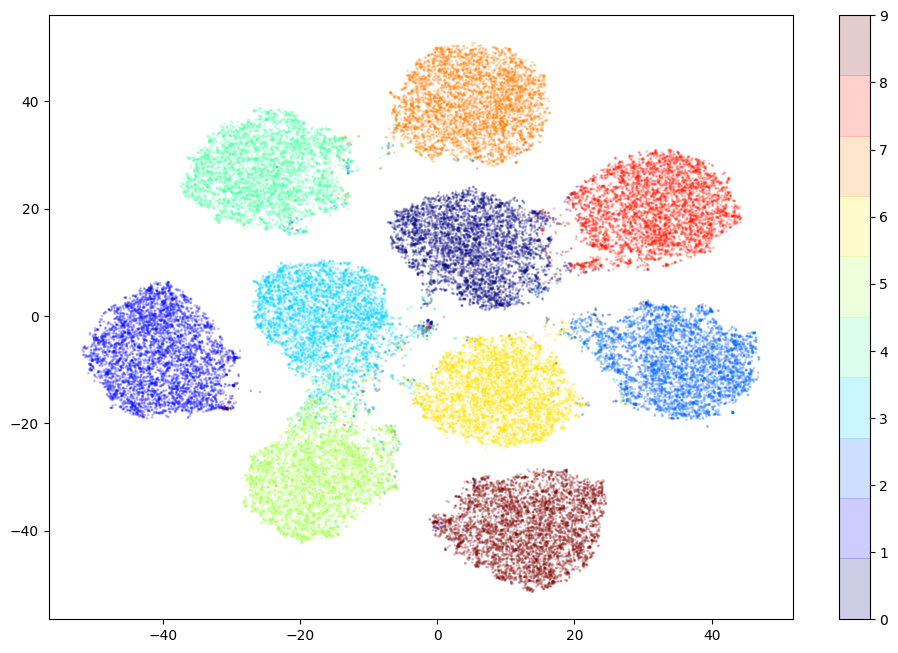

In [17]:
cmap = cm.get_cmap('jet', num_classes)
plt.scatter(xs,ys,s=1.,alpha=0.2,c=total_trainset.targets, cmap=cmap)
plt.colorbar()
plt.show()

Counter({0: 42182, 1: 7636, 2: 182})
Counter({0: 45588, 1: 4337, 2: 75})
Counter({2: 28077, 0: 18096, 1: 3827})
Counter({0: 48133, 1: 1794, 2: 73})
Counter({1: 27614, 0: 19269, 2: 3117})
Counter({0: 40927, 1: 4616, 2: 4457})
Counter({0: 32329, 2: 8978, 1: 8693})
Counter({0: 45377, 1: 4195, 2: 428})
Counter({0: 44421, 2: 3727, 1: 1852})
Counter({0: 31163, 1: 18683, 2: 154})


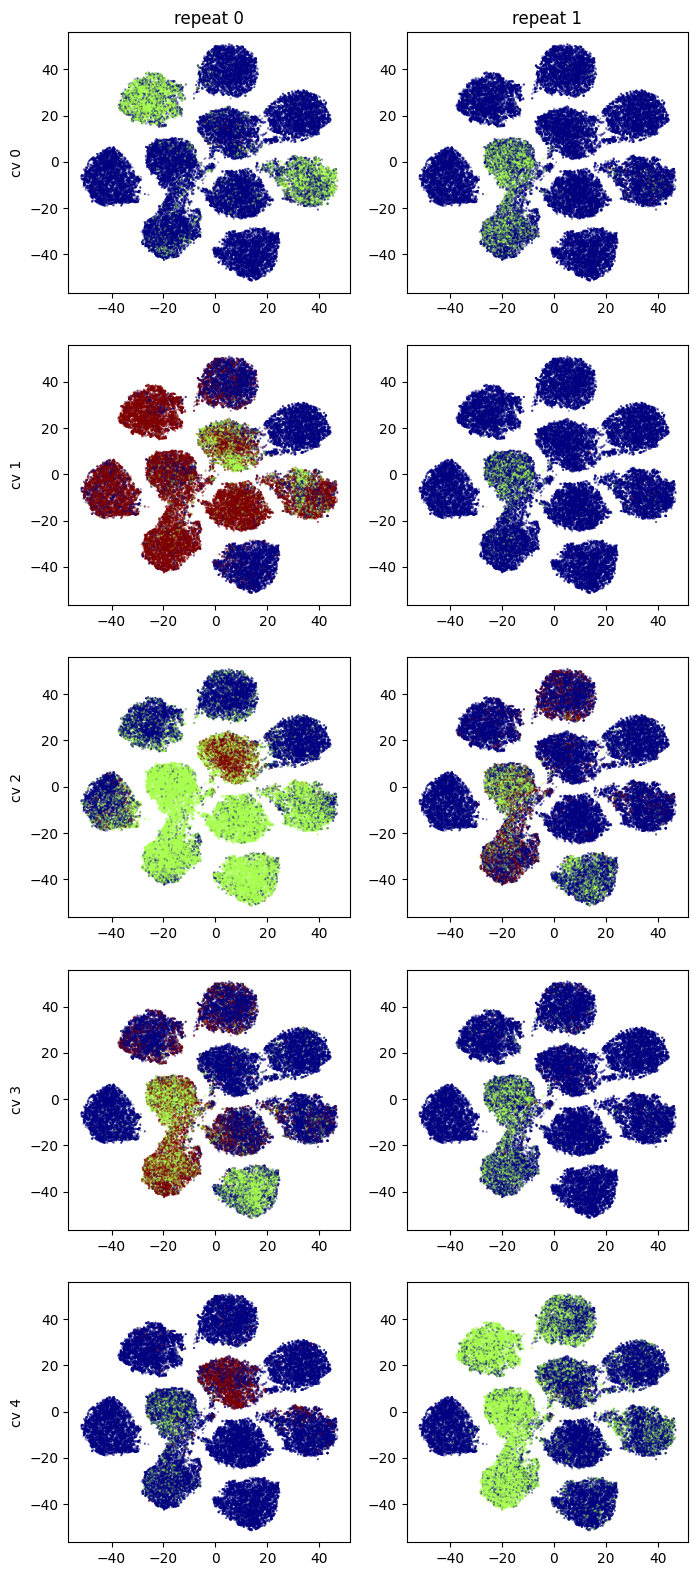

In [18]:
fig, axes = plt.subplots(cv_num, repeat, figsize=(4*repeat,4*cv_num))
for cv_id in range(cv_num):
    for r, id_dist in enumerate(gr_dist_move[cv_id]):
        id_dist = torch.max(id_dist,-1)[1].numpy()
#         print(id_dist)
        ax = axes[cv_id][r]
        ax.scatter(xs, ys, c=id_dist, s=0.2, alpha=0.5, label=Counter(id_dist), cmap=cmap)
        print(Counter(id_dist))
        if r == 0:
            ax.set_ylabel(f"cv {cv_id}")
        if cv_id == 0:
            ax.set_title(f"repeat {r}")
#         ax.legend()
plt.show()

Counter({0: 29898, 1: 15897, 2: 4205})
tensor([[0.3436, 0.3322, 0.3242],
        [0.4020, 0.3165, 0.2815],
        [0.4328, 0.3066, 0.2606],
        ...,
        [0.4227, 0.3024, 0.2750],
        [0.6086, 0.2356, 0.1557],
        [0.3978, 0.3213, 0.2810]])


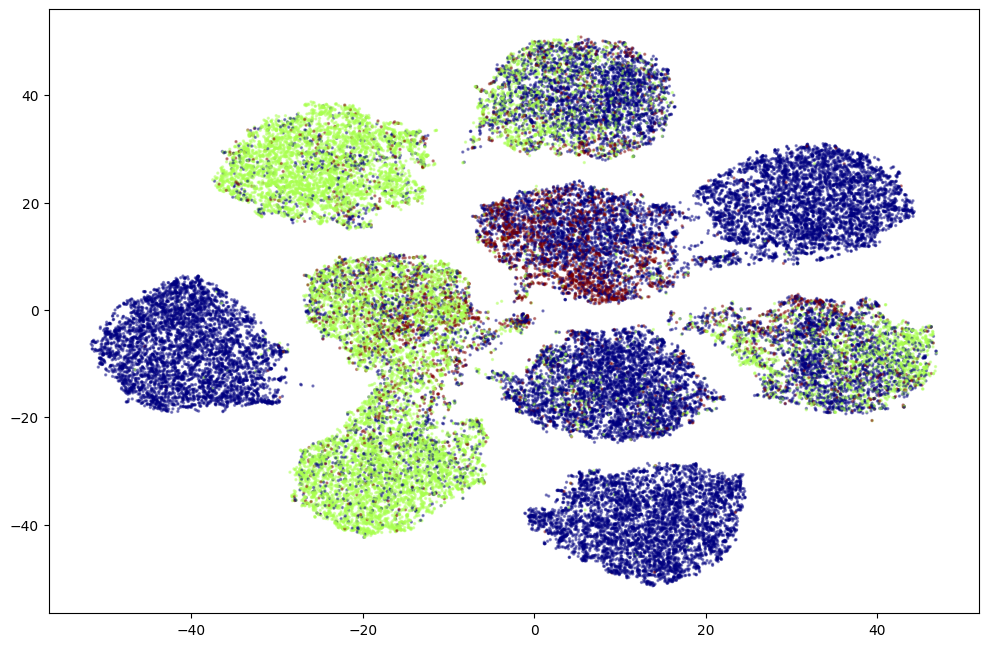

In [19]:
gr_ids = gr_dist_move["last"].max(-1)[1].numpy()
print(Counter(gr_ids))
print(gr_dist_move["last"])
plt.scatter(xs, ys, s=2., alpha=0.4, c=gr_ids, cmap=cmap)

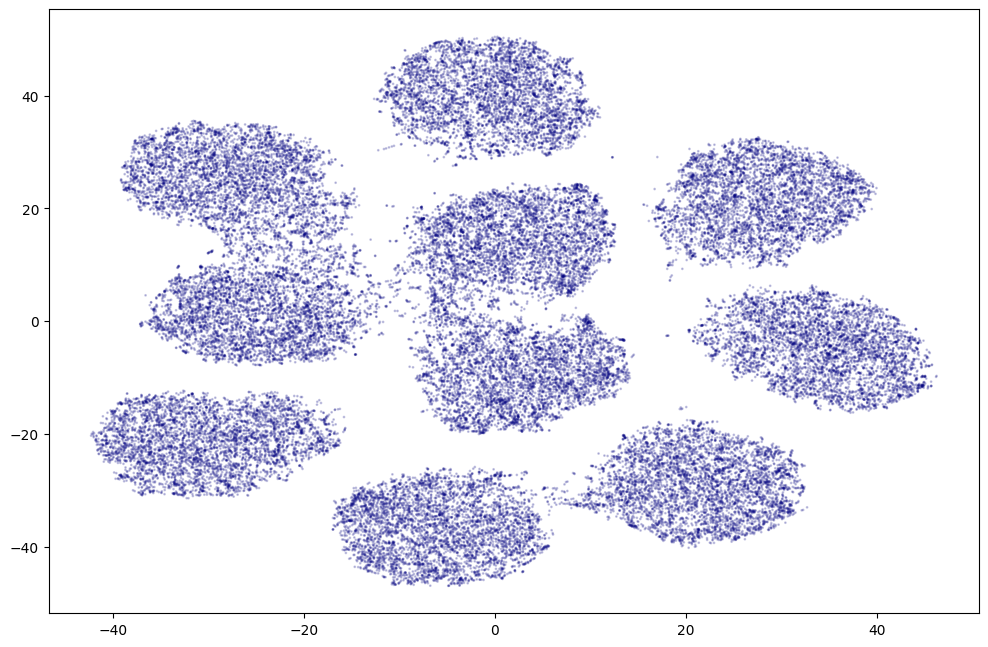

In [13]:
cmap = cm.get_cmap('jet', 2)
plt.scatter(xs,ys,s=1.,alpha=0.2,c=[1 if x<10 else 2 for x in total_trainset.targets], cmap=cmap)
plt.show()

In [27]:
# gr_ids
_, trainloader, validloader, testloader = get_dataloaders("cifar10_svhn", 128, "/home/server32/data/", 0.0, gr_id=0, gr_ids=gr_ids)

10000


In [26]:
print(len(testloader.dataset))

19153


In [6]:
load_path = "/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/logging_b1000/search_cifar10_svhn_wresnet40_2_group2_4_cv0_ratio0.4_bo_result.csv"
result_csv = pd.read_csv(load_path)
minus_loss = result_csv['minus_loss']
acc = result_csv["top1_valid"]

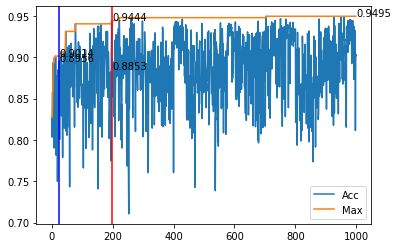

In [7]:
maxline = [max(acc[:x]) for x in range(1,len(acc))]
plt.plot(acc, label="Acc")
plt.plot(maxline, label="Max")
plt.axvline(x=199,c='red')
plt.text(200, acc[199], "{:.4f}".format(acc[199]))
plt.text(200, maxline[198], "{:.4f}".format(maxline[198]))
plt.axvline(x=24,c='blue')
plt.text(25, acc[24], "{:.4f}".format(acc[24]))
plt.text(25, maxline[23], "{:.4f}".format(maxline[23]))
plt.text(len(acc), maxline[-1], "{:.4f}".format(maxline[-1]))
plt.legend()
plt.show()